*Francisco Javier Sáez Maldonado*

# Ejercicios Tema 3: Regresión

In [1]:
suppressMessages(library(tidyverse))
suppressMessages(library(reshape2))
suppressMessages(library(KernSmooth))
defaultW <- getOption("warn")
options(warn = -1)
options(repr.plot.width=12, repr.plot.height=8)

library(tidyverse)
library(ggplot2)
library(KernSmooth)

# Ejercicio 1
    
Los datos del fichero *Datos-geyser.txt* corresponden al día de la observación (primera
columna), el tiempo medido en minutos (segunda columna Y ) y el tiempo hasta la siguiente
erupción (tercera columna X) del geyser *Old-Faithful* en el parque norteamericano de
*Yellowstone*.

a) Representa gráficamente los datos, junto con el estimador de Nadaraya-Watson de la
función de regresión de Y sobre X.

b) Representa gráficamente los datos, junto con el estimador localmente lineal de la función
de regresión de Y sobre X.
 

Comenzamos leyendo los datos del conjunto de datos especificado, quedádonos con las columnas que nos interesan para el análisis.

In [2]:
df <- data.frame(read.table("Datos-geyser.txt", header = TRUE))[, c("X","Y")]
n <- nrow(df)
head(df)

,X,Y
,<dbl>,<int>
1,4.4,78
2,3.9,74
3,4.0,68
4,4.0,76
5,3.5,80
6,4.1,84


Estamos preparados para dibujar el **apartado a**. Usamos la función `geom_smooth` pasándole como parámetro `method = loess` y parámetros del método `degree = 0`, que nos dará el estimador de Nadayara-Watson de los datos.

`geom_smooth()` using formula 'y ~ x'



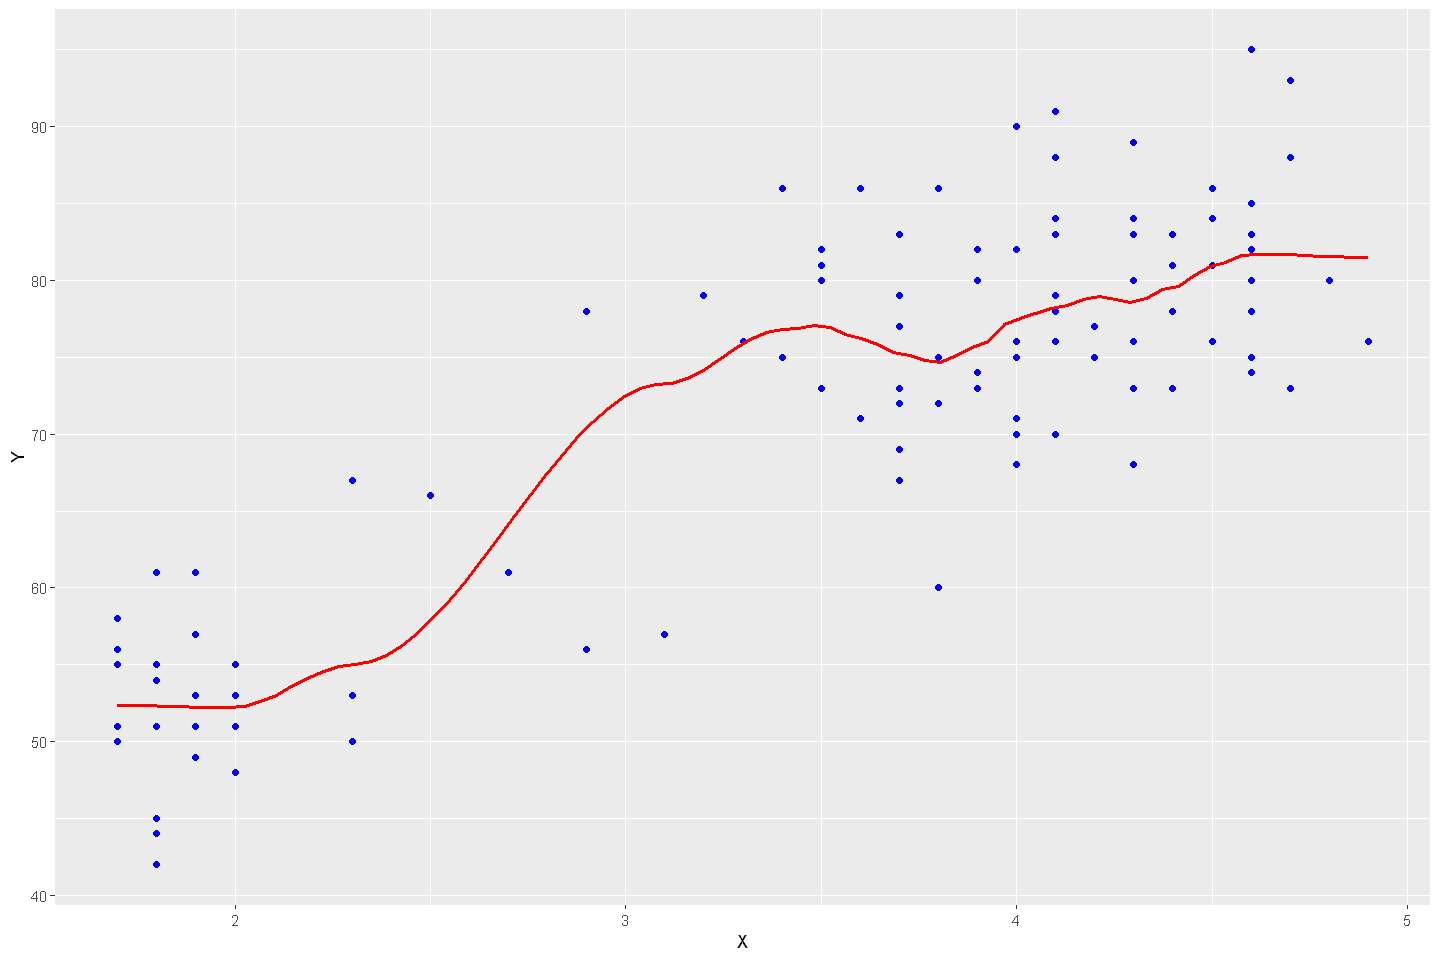

In [3]:
ggplot(df,aes(X,Y)) +
    geom_point(color = "blue")+
    geom_smooth( method = 'loess', se = FALSE, span = 0.25, method.args = list(degree=0), col = 'red')



A continuación, queremos hacer para el **apartado b** el estimador localmente lineal. Debemos volver a usar la función `geom_smooth` con `method = loess`, pero ahora le damos como parámetro a este método `degree = 1`, para obtener el estimador localmente lineal.

`geom_smooth()` using formula 'y ~ x'



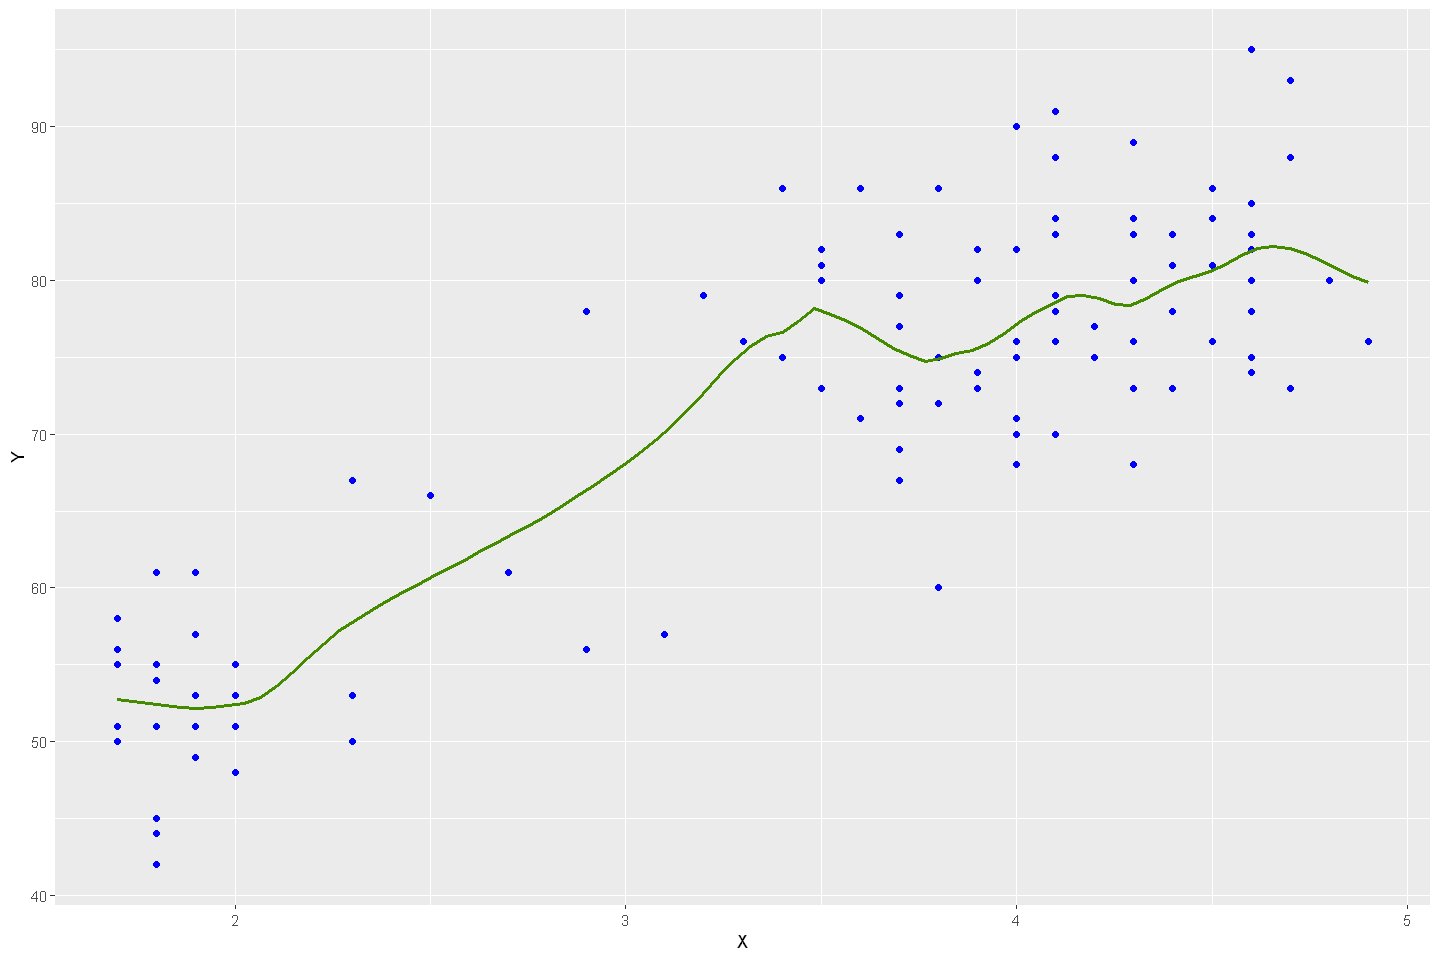

In [4]:
ggplot(df,aes(X,Y)) +
    geom_point(color = "blue")+
    geom_smooth( method = 'loess', se = FALSE, span = 0.25, method.args = list(degree=1), col = 'chartreuse4')

Con objeto de comparar ambos estimadores, vamos a dibujar los dos en el mismo gráfico para observar sus diferencias:

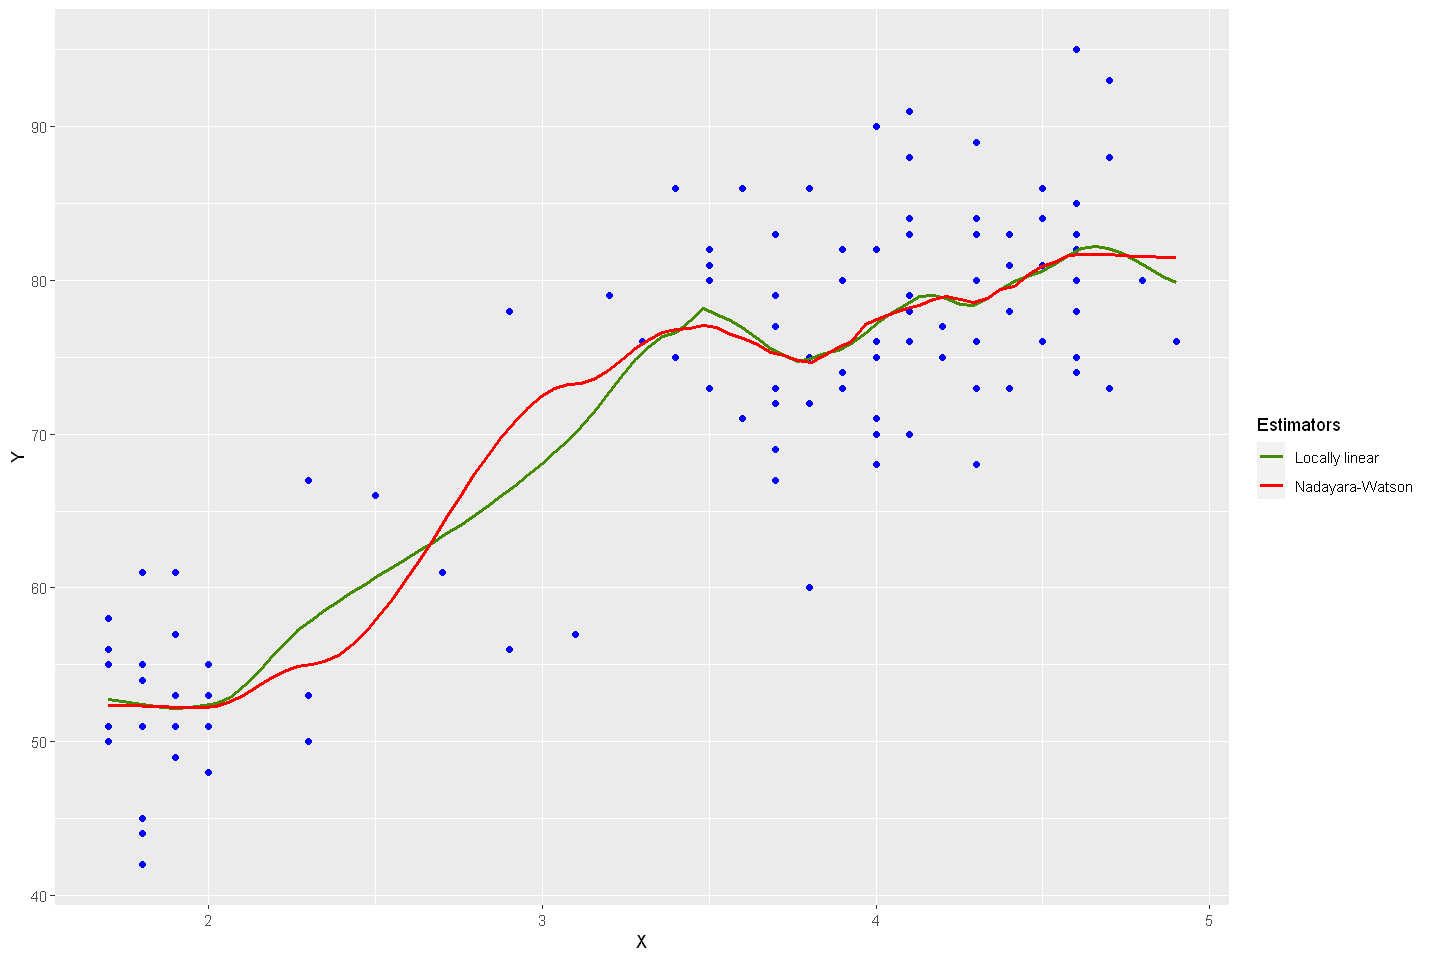

In [5]:
ggplot(df,aes(X,Y)) +
    geom_point(color = "blue")+
    geom_smooth(aes(colour="Locally linear"),formula=y~x, method = 'loess', se = FALSE, span = 0.25, method.args = list(degree=1))+
    geom_smooth(aes(colour="Nadayara-Watson"),formula=y~x,  method = 'loess', se = FALSE, span = 0.25, method.args = list(degree=0))+
    scale_color_manual(name = "Estimators", values = c('chartreuse4','red'))

Como vemos, ambos estimadores son más parecidos en las regiones donde tenemos una mayor densidad de puntos, distanciándose en las regiones donde esta densisdad es menor.

# Ejercicio 4

Se considera el siguiente modelo de regresión lineal múltiple:

$$
Y_i = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \beta_3 x_{i3} + \epsilon_i , \quad \epsilon_i \sim \mathcal N(0,\sigma^2), \quad i = 1,\dots,n \ \ \ (1)
$$

Se dispone de $n=20$ observaciones con las que se ajustan todos los posibles submodelos del
modelo (1), obteniéndose para cada uno de ellos las siguientes sumas de cuadrados de los
residuos (todos los submodelos incluyen un término independiente).

| Variables incluidas en el modelo | SCR       |
|:----------------------------------:|:-----------:|
| Término independiente.           | $42644.00$|
| $x_1$                            | $8352.28$ |
| $x_2$                            | $36253.69$|
| $x_3$                            | $36606.19$|
| $x_1,x_2$                        | $7713.13$ |
| $x_1,x_3$                        | $762.55$  |
| $x_2,x_3$                        | $32700.17$|
| $x_1,x_2,x_3$                    | $761.41$  |

**a)** Calcula la tabla de análisis de la varianza para el modelo $(1)$ y contrasta a nivel $\alpha = 0.05$ la hipótesis nula:
$$
H_0 : \beta_1 = \beta_2 = \beta_3 = 0
$$

**Solución**

Para calcular la tabla de análisis de la varianza necesitamos:

- Grados de libertad (df)
- Suma de cuadrados explicada (SumSq)
- Media de los cuadrados (MeanSq)
- Valor del estadístico $F$, calculado como $$F= \frac{SCE/p}{SCR/(n-p-1)} $$
- P-value, que sabemos que lo podemos calcular usando la región crítica $$ R = \left\{ \frac{(\mbox{SCR}_0 - \mbox{SCR})/k}{\mbox{SCR}/(n-p-1)} > F_{k,n-p-1;\alpha}  \right\}$$.

Necesitamos saber cuál es la suma de cuadrados explicada. Sin embargo, con la información que tenemos en la tabla podemos razonar del siguiente modo: Sabemos que en un modelo constante $Y_i = \beta_0 + \epsilon_i$, el valor de $\beta_0$ que minimiza el error cuadrátrico medio entre los valores observados y las predicciones que nuestro modelo hace es justamente $\hat \beta_0 = \bar Y$. Ahora, usando con este modelo reducido que la varianza total es igual a la suma de la varianza explicada por el modelo más la varianza no explicada por el mismo:

$$
SCE = SCT - SCT = \sum(\bar Y - Y_i)^2 - \sum (\hat Y_i - Y_i)^2 = \sum (\hat \beta_0 - Y_i)^2 - \sum(\hat Y_i - Y_i)^2 = SCR_0 - SCR
$$

Así que podemos usar la diferencia entre la suma de los cuadrados de los residuos del modelo reducido que tiene solo el término independiente y la suma de los cuadrados de los residuos del modelo completo $(1)$. 


In [6]:
n <- 20
p <- 3

srsums <- c(42644.00,8352.28,36253.69,36606.19,7713.13,762.55,32700.17,761.41)
scr <- srsums[8]
sce <- srsums[1] - scr

models <- c("Model","Residuals")
df <- c(p,n-p-1)
sumsq <- c(sce,scr)
meansq <- (sumsq/df)
f_val <- c(meansq[1]/meansq[2],NA)
pval <- c(pf(f_val[1], df1 = p , df2 = n-p-1, lower.tail = FALSE), NA)

table <- data.frame(Model=models,Df = df, Sumsq = sumsq, Meansq = meansq, F = f_val, P_val = pval)
table


Model,Df,Sumsq,Meansq,F,P_val
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Model,3,41882.59,13960.86333,293.3686,3.421043e-14
Residuals,16,761.41,47.58812,NA,NA


 
 Ahora, se nos pide contrastar la hipótesis nula $H_0$. Para ello, usamos el estadístico $F$ comentado anteriormente. Además, sabemos que bajo $H_0$ se sigue una distribución $F_{3;16}$, por lo que nuestro p-valor es $$ p = \mathbb P[F_{3;16} > F] = 3.42 \cdot 10^{-14} < 0.05 = \alpha,$$
 por lo podemos **rechazar** la hipótesis nula de que $\beta_1 = \beta_2 = \beta = 3 = 0$.
 
 **b)** En el modelo $(1)$, contrasta a nivel $\alpha = 0.05$ las dos hipótesis nulas siguientes:
 - $H_0: \beta_2 = 0$
 - $H_0 = \beta_1 = \beta_3 = 0$.
 
 
**Solución**
 
 En ambos casos, necesitamos ahora un nuevo estimador, que sabemos que es 
$$F =  \frac{(\mbox{SCR}_0 - \mbox{SCR})/k}{\mbox{SCR}/(n-p-1)} \equiv F_{k,n-p-1}$$
donde $n$ es el número de muestras, $p$ el número de variables del modelo completo y $k$ el rango de la matriz $A$, matriz que verifica que $H_0 = A\mathbf{\beta} = 0$. En este caso, $SCR_0$ es el valor de la suma de los cuadrados de los residuos del modelo ajustado bajo la hipótesis nula, valor que obtendremos de la tabla del enunciado.

- Si $H_0 = \beta_2$ = 0, tenemos que la matriz $A$ tiene que ser $$ A = (0 \ 0 \ 1 \ 0),$$ por lo que $k = rango(A) =  1$.

In [7]:
k <- 1
F <- ((srsums[6] - scr)/k)/(scr/(n-p-1))
pval1 <- pf(F, df1 = k, df2 = n-p-1, lower.tail = FALSE)
print("p-value:")
pval1

[1] "p-value:"


[1] 0.8789337

En este caso, hemos obtenido un $p-$value de $0.8789$, que es considerablemente mayor que $0.05$, por lo que no tenemos evidencia para rechazar la hipótesis nula de que la segunda variable no es significativa para la predicción de nuestro modelo.

- Si $H_0 : \beta_1 = \beta_3 = 0$, en este caso podemos considerar la siguiente matriz A:
$$
A = \begin{pmatrix} 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1\end{pmatrix},
$$
que cumple que $H_0 = A \mathbf{\beta}$ y que, como tiene dos columnas independientes, tiene como $k = rango(A) = 2$. Repetimos los cálculos anteriores pero ahora usando los valores necesarios de la tabla inicial:

In [8]:
k <- 2
F <- ((srsums[3] - scr)/k) / (scr/(n-p-1))
pval2 <- pf(F, df1=k, df2=n-p-1,lower.tail=FALSE)
print("p-value")
pval2

[1] "p-value"


[1] 3.785566e-14

En este último caso, hemos obtenido que el $p-$value es de $3.79\cdot 10^{-14}$, que es considerablemente menor que $\alpha = 0.05$, por lo que rechazamos la hipótesis nula de que tanto $\beta_1$ como $\beta_3$ no son importantes para las predicciones de nuestro modelo.

# Ejercicio 6

Sean $Y_1,Y_2,Y_3$ tres variables aleatorias independientes con distribución normal. Supongamos que $\mu,\lambda \in \mathbb R$ y que
- $Y_1 \sim \mathcal N(\mu,\sigma^2)$
- $Y_2 \sim \mathcal N(\lambda,\sigma^2)$
- $Y_3 \sim \mathcal N(\mu + \lambda,\sigma^2)$

**a)** Demuestra que el vector $\mathbf Y = (Y_1,Y_2,Y_3)'$ verifica el modelo de regresión múltiple $\mathbf Y = \mathbf{X\beta} + \mathbf \epsilon$. Para ello, determina la matriz de diseño $\mathbf X$, el vector de parámetros $\mathbf \beta$, y la distribución de las variables de error $\mathbf \epsilon$.

**b)** Calcula los estimadores de máxima verosimilitud (equivalentemente, el de mínimos cuadrados) de $\lambda$ y $\mu$.

**c)** Calcula la distribución del vector $(\hat \lambda, \hat \mu)'$ formado por los estimadores calculados en el apartado anterior.

**Solución**

**Apartado a)**. Sabemos que El vector $\mathbf Y = (Y_1,Y_2,Y_3)'$ Sigue una distribución normal multivariante $\mathbf Y \sim \mathcal N_3 (\mathbf \mu, \mathbf \Sigma)$, donde $\mathbf {\mu} = (\mu, \lambda, \lambda + \mu)$ es el vector de medias y $\mathbf \Sigma$ es la matriz de covarianzas. Ahora basta ver que, considerando 
$$
\mathbf X = \begin{pmatrix} 1 & 0 \\ 0 & 1 \\ 1 & 1\end{pmatrix}\quad \text{ y }\quad \mathbf \beta = \begin{pmatrix} \mu \\ \lambda \end{pmatrix},
$$
y que, puesto que las variables son independientes
$$
\mathbf \Sigma = \sigma^2 \mathbb I_3,
$$ 
obtenemos que 
$$
\mathbf Y \sim \mathcal N_3 (\mathbf{X\beta},\sigma^2 \mathbb I_3).
$$

Con esto sabemos, por un resultado visto en teoría, que si tenemos que 

$$ 
Y|X   \equiv \mbox{N}_n(X\beta,\sigma^2 \mathbb{I}_n) \Leftrightarrow Y = X\beta + \epsilon, \ \ \epsilon|X\equiv \mbox{N}_n(0,\sigma^2 \mathbb{I}_n)
$$

Así que podemos decir que nuestro vector $\mathbf Y$ verifica el modelo de regresión múltiple.

**Apartado b)**.

Ahora, para obtener el estimador de máxima verosimilitud **en general** (es decir: para cualquier modelo de regresión lineal), que en este caso es el de mínimos cuadrados) realizar el cálculo:

$$
\hat{\beta} = (\mathbf X' \mathbf X)^{-1}\mathbf X'\mathbf Y
$$

In [9]:
suppressMessages(library("MASS"))
suppressMessages(library("FRACTION"))

library("MASS")
library("FRACTION")
X = cbind(c(1,0,1),c(0,1,1))

mat = fra.m(ginv(t(X) %*% X)%*%t(X))
mat

2 / 3,-1 / 3,1 / 3
-1 / 3,2 / 3,1 / 3


Por lo que, nuestro estimador de máxima verosimilitud es

$$
\hat \beta  = \begin{pmatrix} \hat \mu \\ \hat  \lambda \end{pmatrix} = \frac{1}{3}\begin{pmatrix} 2 & -1 & 1 \\ -1 & 2 & 1 \end{pmatrix} \begin{pmatrix} Y_1 \\ Y_2 \\ Y_3 \end{pmatrix} = \frac{1}{3} \begin{pmatrix} 2 Y_1 - Y_2 + Y_3 \\ -Y_1 + 2 Y_2 + Y_3 \end{pmatrix}
$$

**Apartado c)**

Por último, sabemos también por otro resultado visto en teoría que la distribución de $\hat \beta$ viene dada por 

$$
\hat{\beta} \equiv \mathcal{N}_{p+1}(\beta,\sigma^2 (X'X)^{-1}),
$$

donde, en este caso $p = 1$, luego sería una normal bidimensional. Calculamos $(X'X)^{-1}$:


In [10]:
fra.m(ginv(t(X) %*% X))

2 / 3,-1 / 3
-1 / 3,2 / 3


Por lo que, la distribución del vector $\hat \beta = (\hat \mu, \hat \lambda)'$ es :

$$
\hat{\beta} \equiv \mathcal{N}_{2}\left(\begin{pmatrix} \mu \\ \lambda \end{pmatrix},\frac{\sigma^2}{3} \begin{pmatrix}2 & -1 \\ -1 & 2 \end{pmatrix}\right)
$$

# Ejercicio 10

Los datos fuel2001 del fichero `combustible.RData` corresponden al consumo de combustible (y otras variables relacionadas) en los estados de EE.UU. Se desea explicar la variable `FuelC` en función del resto de la información.

**Apartado a)** representa en un plano las dos primeras componentes principales de estos datos estandarizados (consulta la ayuda de `prcomp`) ¿ Son suficientes estas dos componentes para explicar un alto porcentaje de la varianza ?


In [11]:
load("combustible.RData")
head(fuel2001)

,Drivers,FuelC,Income,Miles,MPC,Pop,Tax
,<int>,<int>,<int>,<int>,<dbl>,<int>,<dbl>
AL,3559897,2382507,23471,94440,12737.00,3451586,18.0
AK,472211,235400,30064,13628,7639.16,457728,8.0
AZ,3550367,2428430,25578,55245,9411.55,3907526,18.0
AR,1961883,1358174,22257,98132,11268.40,2072622,21.7
CA,21623793,14691753,32275,168771,8923.89,25599275,18.0
CO,3287922,2048664,32949,85854,9722.73,3322455,22.0


Extraemos la columna de los datos que queremos usar como variable a predecir, y estandarizamos los datos para hallar las componentes principales.

In [12]:
Y <- fuel2001$FuelC
fuel2001$FuelC <- NULL

# Standardize data
standardized <- scale(fuel2001)

In [13]:
principal_comps <- prcomp(standardized)

Podemos hallar ahora las componentes principales y dibujarlas.

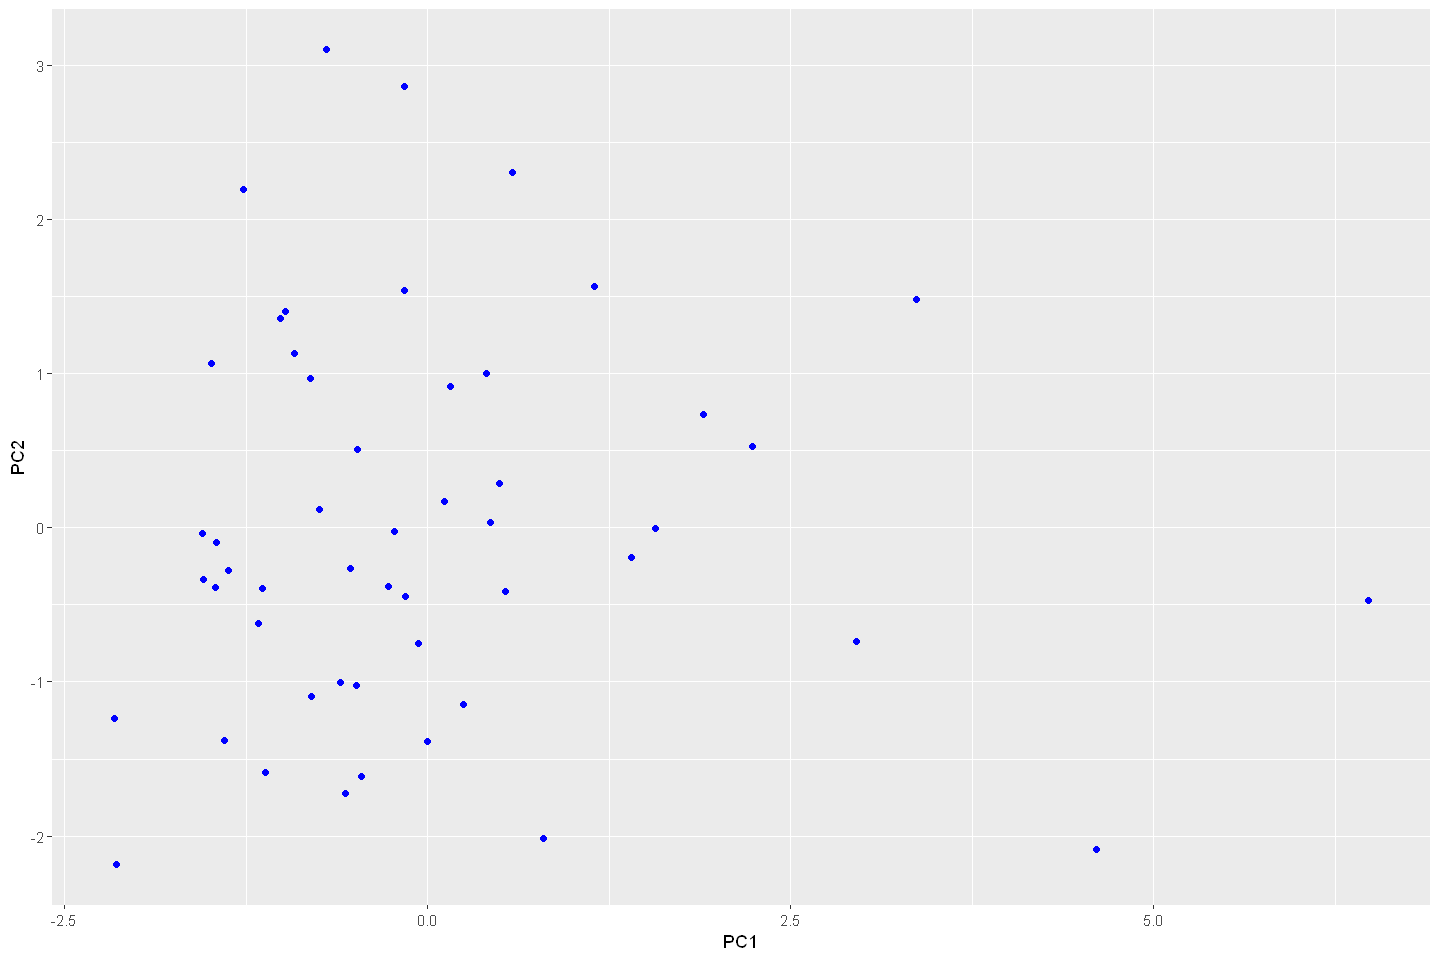

In [14]:
pca_fuel <- data.frame(
  PC1 = principal_comps$x[, 1],
  PC2 = principal_comps$x[, 2]
)
ggplot(pca_fuel, aes(x = PC1, y = PC2)) +
  geom_point(col="blue")

In [15]:
summary(principal_comps)

Importance of components:
                          PC1    PC2    PC3     PC4     PC5     PC6
Standard deviation     1.6518 1.2593 0.9968 0.63696 0.53093 0.06854
Proportion of Variance 0.4547 0.2643 0.1656 0.06762 0.04698 0.00078
Cumulative Proportion  0.4547 0.7190 0.8846 0.95224 0.99922 1.00000

Vemos que si sumamos la proporción de la varianza  (*Cumulative Proportion*) que explican las dos primeras componentes principales es $0.7190$. Este porcentaje aunque es razonablemente alto, está dejando sin explicar casi un $30\%$ de la varianza, por lo que quizá  se necesitarían $3$ variables (vemos que, si usamos 3 la proporción acumulada pasa a ser casi un $89\%$) para que fuese un valor más conveniente de porcentaje de la varianza explicada.

**Apartado b)** Ajusta el modelo completo con todas las variables. En este modelo completo, contrasta la hipótesis nula de que los coeficientes de las variables `Income,MPC` y `Tax` son simultáneamente iguales a cero. 

Realizamos el ajuste del modelo completo utilizando la orden `lm`. 

In [16]:
reg <- lm(Y~., data=fuel2001)
summary(reg)


Call:
lm(formula = Y ~ ., data = fuel2001)

Residuals:
     Min       1Q   Median       3Q      Max 
-1480910  -158802    19267   174208  1090089 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -4.902e+05  8.199e+05  -0.598 0.552983    
Drivers      6.368e-01  1.452e-01   4.386 7.09e-05 ***
Income       7.690e+00  1.632e+01   0.471 0.639793    
Miles        5.850e+00  1.621e+00   3.608 0.000784 ***
MPC          4.562e+01  3.565e+01   1.280 0.207337    
Pop         -1.945e-02  1.245e-01  -0.156 0.876586    
Tax         -2.087e+04  1.324e+04  -1.576 0.122235    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 398400 on 44 degrees of freedom
Multiple R-squared:  0.9808,	Adjusted R-squared:  0.9782 
F-statistic: 374.6 on 6 and 44 DF,  p-value: < 2.2e-16


Obtenemos que nuestro coeficiente $R^2$ es de $\approx0.98$, que es bastante cercano a $1$, por lo que podemos decir que estamos explicando la mayoría de la variabilidad de nuestros datos. 

Ajustamos ahora el modelo en el que hacemos que `Income, MPC` y `Tax` son iguales a cero. Esto es lo mismo que decir que el resto de variables son las que aportan al modelo, lo cual lo podemos indicar en la función `lm` de la forma:
`lm(variable_a_predecir ~ v_dep_1 + ... + v_dep_n,...)` donde `v_dep_i` es la variable dependiente $i-$ésima.

In [17]:

reg0 <- lm(Y~Drivers + Pop + Miles, data=fuel2001)
summary(reg0)


Call:
lm(formula = Y ~ Drivers + Pop + Miles, data = fuel2001)

Residuals:
     Min       1Q   Median       3Q      Max 
-1486667  -209534    25497   186536  1083358 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.374e+05  1.047e+05  -2.268 0.027964 *  
Drivers      7.156e-01  1.446e-01   4.949 9.98e-06 ***
Pop         -8.879e-02  1.229e-01  -0.722 0.473593    
Miles        6.125e+00  1.472e+00   4.161 0.000134 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 408800 on 47 degrees of freedom
Multiple R-squared:  0.9784,	Adjusted R-squared:  0.977 
F-statistic: 709.9 on 3 and 47 DF,  p-value: < 2.2e-16


En este caso, tenemos un ligero descenso en el coeficiente $R^2$, aunque el descenso sea de apenas unas centésimas, por lo que este modelo está consiguiendo muy buenos resultados sin usar el mismo número de variables que usaba el anterior.

Contrastamos la hipótesis nula $H_0$ haciendo la tabla *Anova*:

In [18]:
anova(reg0, reg)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,47,7.855597e+12,NA,NA,NA,NA
2,44,6.984313e+12,3,871284719267,1.829649,0.1556908


Vemos que obtenemos un $p-$valor de $\approx 0.16$, así que si consideramos (como es habitual) un $\alpha = 0.05$, tendríamos que $p-$value $> \alpha$ por lo que no tendríamos evidencia suficiente para rechazar $H_0$, es decir, que puede ser que las variables que hemos eliminado no tengan una gran influencia en el modelo. Esto tiene sentido con el breve análisis anterior en el que comentábamos que el modelo con menos variables es prácticamente igual al modelo completo.

**Apartado c)** De acuerdo con el método iterativo hacia adelante y el criterio BIC,  ¿ cuál es el modelo óptimo ?

Para resolver este apartado, vamos a usar la función `regsubsets` de `leaps`, utilizada en clase para realizar el método paso a paso hacia adelante. A continuación, utilizaremos un criterio de selección (en este caso, el **BIC**), para escoger el mejor modelo

In [19]:

all_models <- leaps::regsubsets(Y ~ ., data=fuel2001)
summary_all <- summary(all_models)
summary_all

Subset selection object
Call: regsubsets.formula(Y ~ ., data = fuel2001)
6 Variables  (and intercept)
        Forced in Forced out
Drivers     FALSE      FALSE
Income      FALSE      FALSE
Miles       FALSE      FALSE
MPC         FALSE      FALSE
Pop         FALSE      FALSE
Tax         FALSE      FALSE
1 subsets of each size up to 6
Selection Algorithm: exhaustive
         Drivers Income Miles MPC Pop Tax
1  ( 1 ) "*"     " "    " "   " " " " " "
2  ( 1 ) "*"     " "    "*"   " " " " " "
3  ( 1 ) "*"     " "    "*"   " " " " "*"
4  ( 1 ) "*"     " "    "*"   "*" " " "*"
5  ( 1 ) "*"     "*"    "*"   "*" " " "*"
6  ( 1 ) "*"     "*"    "*"   "*" "*" "*"

Drivers  Income   Miles     MPC     Pop     Tax 
    "*"     " "     "*"     " "     " "     "*"

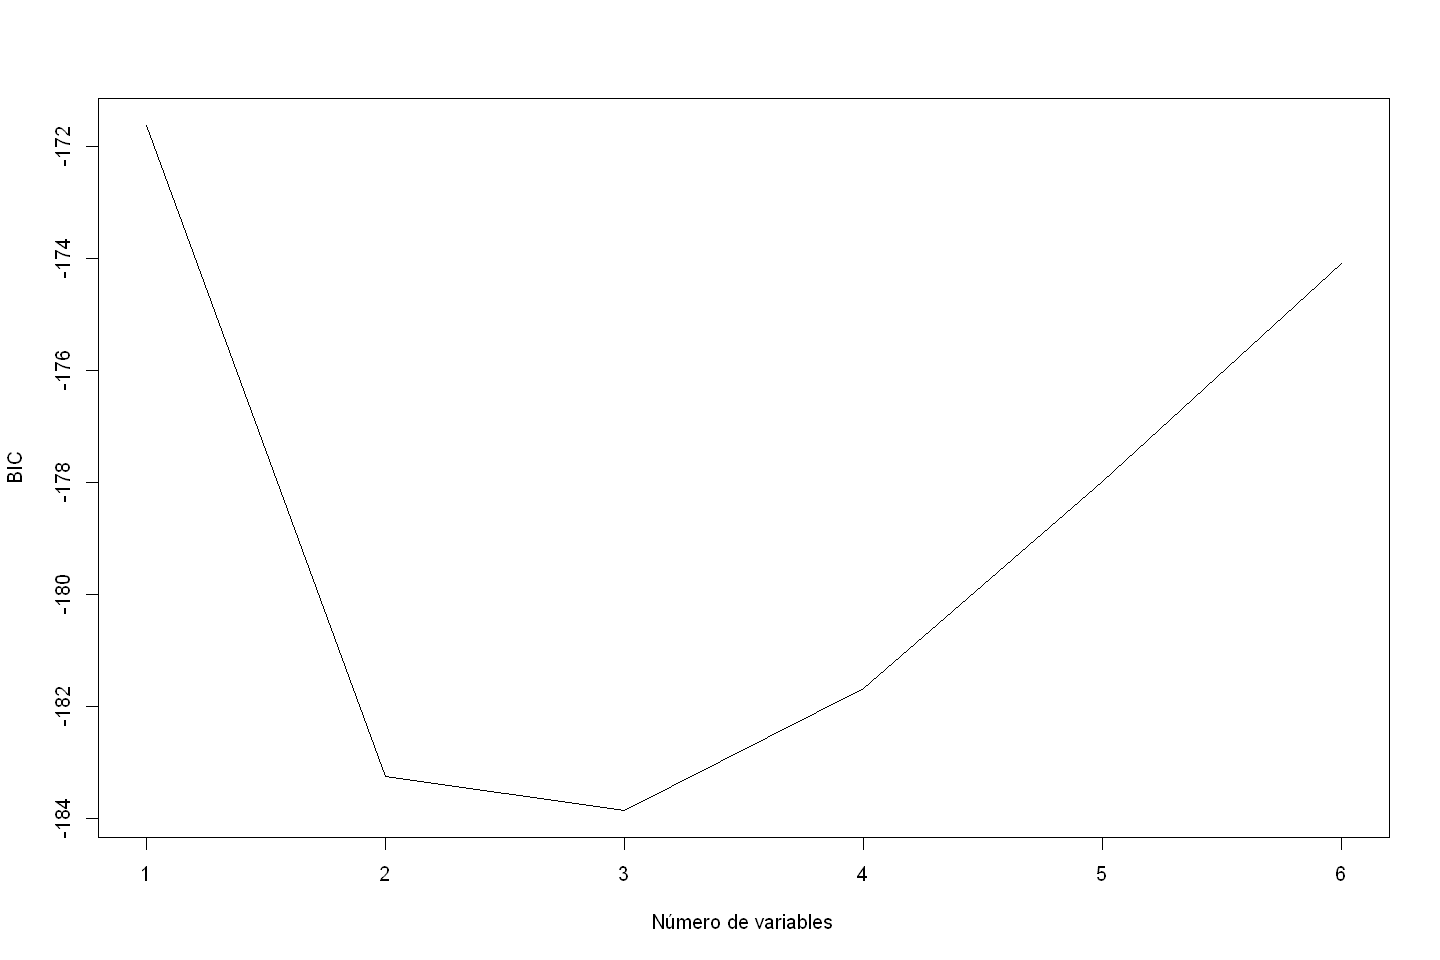

In [20]:
index <- which.min(summary_all$bic)
summary_all$outmat[index, ]

plot(summary_all$bic ,xlab =" Número de variables ", 
     ylab="BIC",type="l")

Como vemos, según el criterio iterativo hacia adelante y el criterio BIC, de selección de modelos, obtenemos que el mejor modelo es el que tiene $3$ variables más el término independiente, pues es el que nos resulta en un valor menor del coeficiente **BIC**. Por tanto, el modelo seleccionado es:

$$
Y = \beta_0 + \beta_1 \operatorname{Income} + \beta_2 \operatorname{Miles} + \beta_3 \operatorname{Tax}
$$

**Apartado d)** Ajusta el modelo usando lasso, con el parámetro de regularización seleccionado mediante validación cruzada.

Para ello, hemos visto en clase que podemos usar la biblioteca `glmnet`, usando `cv.glmnet(datos,etiquetas,alpha)` para encontrar el mejor parámetro de regularización $\lambda$. Tenemos que:

- Si le indicamos $\alpha = 1$, se busca el mejor parámetro usando el estimador Lasso.

- Si, por el contrario, le indicamos $\alpha = 0$, se busca el mejor parámetro $\lambda$ usando el estimador Ridge (esto será útil para el próximo apartado).


Procedemos a buscar el mejor parámetro de regularización $\lambda$ usando Lasso.

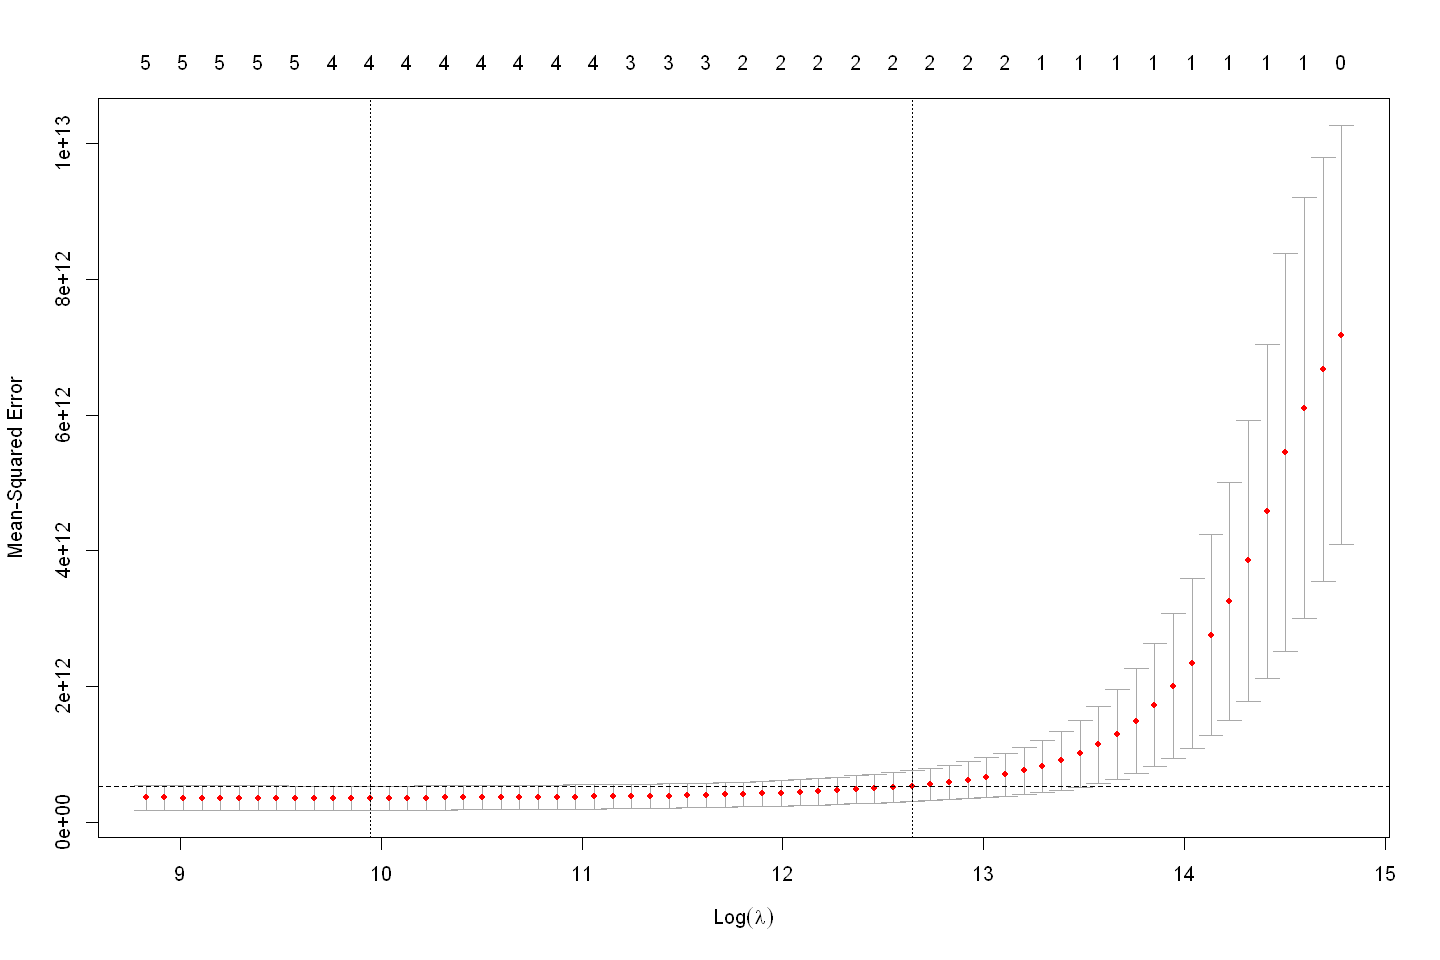

In [21]:
suppressMessages(library('glmnet'))
library('glmnet')
lasso_cv <- cv.glmnet (as.matrix(fuel2001) , Y, alpha = 1)
plot(lasso_cv)
indice <- which(min(lasso_cv$cvm) == lasso_cv$cvm)
abline(h = lasso_cv$cvm[indice] + lasso_cv$cvsd[indice], lty = 2) 

In [22]:
lambda_lasso <- lasso_cv$lambda.1se
print("Lambda found in Lasso")
lambda_lasso
print("Log Lambda found in Lasso")
log(lambda_lasso)

[1] "Lambda found in Lasso"


[1] 309612.4

[1] "Log Lambda found in Lasso"


[1] 12.64308

Como vemos, obtenemos que el mejor parámetro de regularización es un valor bastante grande. Esto es debido a que queremos forzar a que los valores que puedan tomar los coeficientes $\beta_i$ sean pequeños en norma, por lo que debemos reducir bastante los mismos.

Obtenemos finalmente el modelo final con el $\lambda$ encontrado:

In [23]:
final_lasso_model <- glmnet(fuel2001, Y, alpha = 1, lambda = lambda_lasso)
coef(final_lasso_model)

7 x 1 sparse Matrix of class "dgCMatrix"
                      s0
(Intercept) 2.292242e+05
Drivers     5.652140e-01
Income      .           
Miles       2.502297e+00
MPC         .           
Pop         .           
Tax         .           

Como vemos, este modelo se ha quedado únicamente con el término independiente y las variables *Drivers* y *Miles*, por lo que estaríamos ante el modelo:

$$
Y  = \beta_0 + \beta_1 \operatorname{Drivers} + \beta_2 \operatorname{Miles}
$$

**Apartado e)** Ajusta el modelo usando Ridge, con el parámetro de regularización seleccionado mediante validación cruzada.

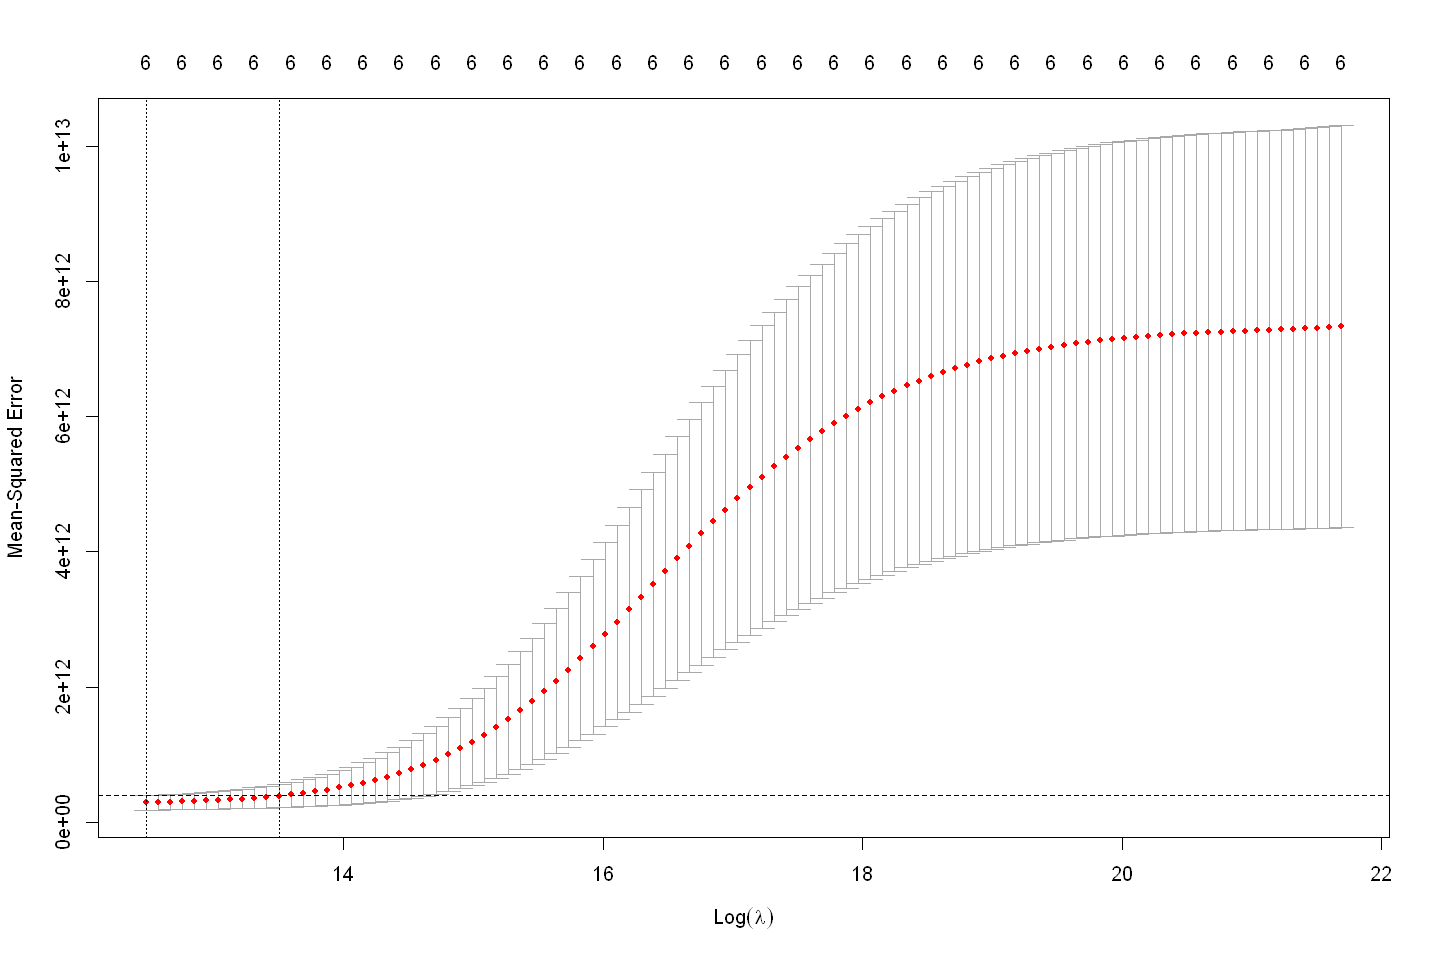

In [24]:

ridge_cv <- cv.glmnet (as.matrix(fuel2001) , Y, alpha = 0)
plot(ridge_cv)
indice <- which(min(ridge_cv$cvm) == ridge_cv$cvm)
abline(h = ridge_cv$cvm[indice] + ridge_cv$cvsd[indice], lty = 2) 

Se puede apreciar como la desviación típica es razonablemente mayor en este caso en comparación con el anterior. Además, fijándonos en los valores que se toman en el eje $x$, vemos que el parámetro $\lambda$ será más grande en este caso.

In [25]:
lambda_ridge <- ridge_cv$lambda.1se
print("Lambda found in Ridge")
lambda_ridge
print("Log Lambda found in Ridge")
log(lambda_ridge)

[1] "Lambda found in Ridge"


[1] 732075.3

[1] "Log Lambda found in Ridge"


[1] 13.50364

Como comentábamos anteriormente, en este caso el $\lambda$ óptimo es bastante superior. Podemos ahora calcular el modelo final usando este $\lambda$

In [26]:
final_ridge_model <- glmnet(fuel2001, Y, alpha = 0, lambda = lambda_ridge)
coef(final_ridge_model)

7 x 1 sparse Matrix of class "dgCMatrix"
                       s0
(Intercept)  9.667589e+04
Drivers      2.590867e-01
Income       1.910420e+01
Miles        8.968968e+00
MPC          2.031487e+00
Pop          2.083279e-01
Tax         -3.327635e+04

Como vemos, en este caso se usan todas las variables, por lo que estaríamos usando el modelo completo.
